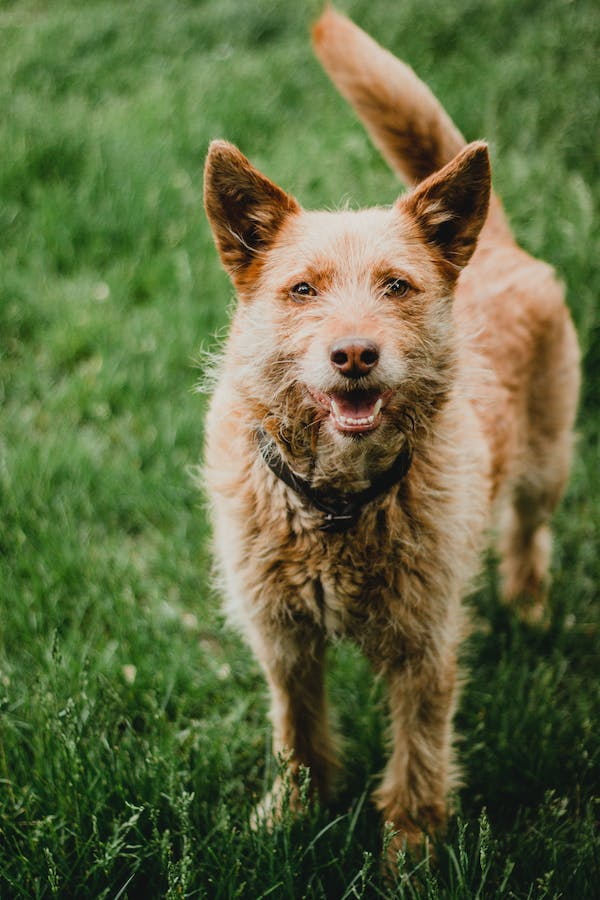

In [16]:
import cv2
from google.colab.patches import cv2_imshow
# Open the image.
img = cv2.imread("download.jpeg")
cv2_imshow(img)

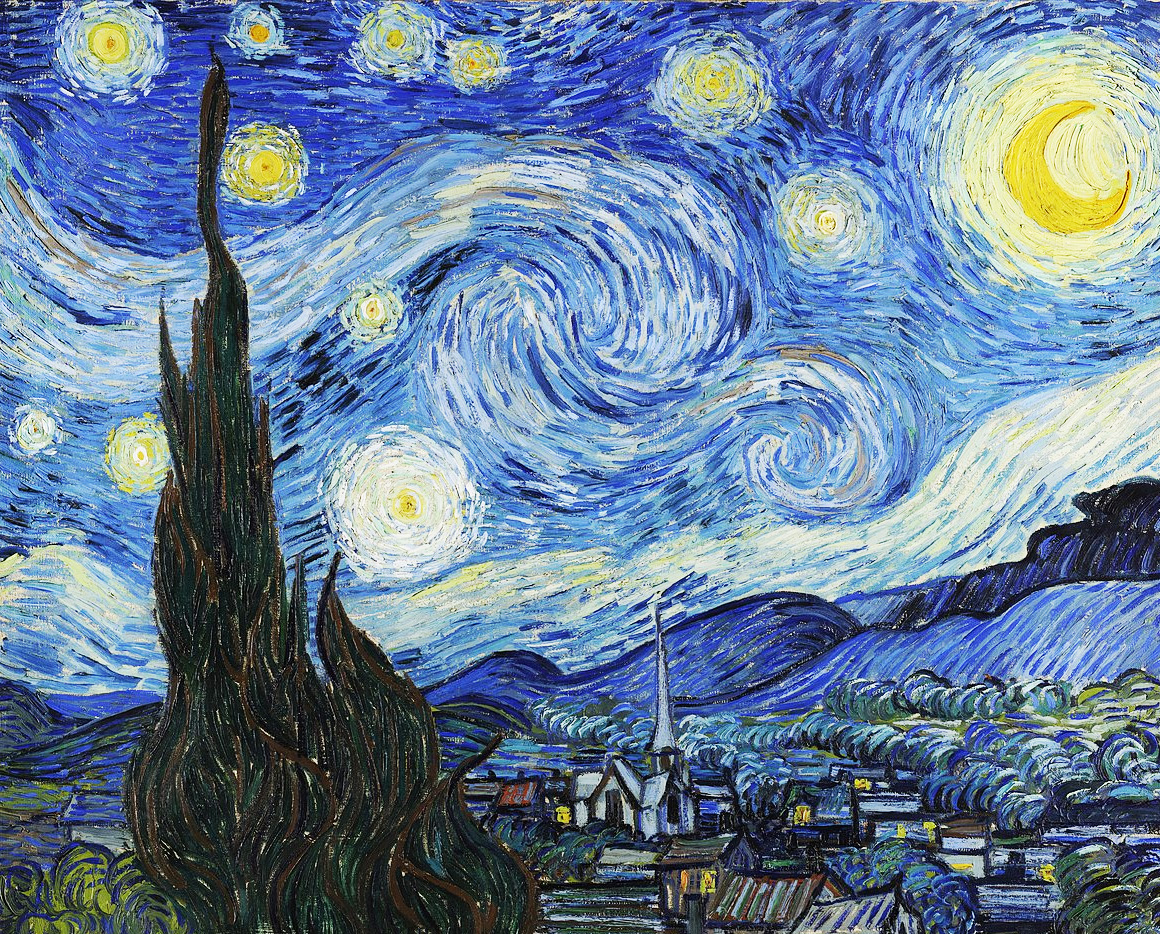

In [17]:
import cv2
from google.colab.patches import cv2_imshow
# Open the image.
img1 = cv2.imread("style.jpg")
cv2_imshow(img1)

In [18]:
from __future__ import print_function

import time
from PIL import Image
import numpy as np

import keras.backend as K
from keras.models import Model
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
# VGG16: Fully Trained 16 layered CNN.
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
#from scipy.misc import imsave
from keras.preprocessing.image import save_img

# Input the Content and Style Images
ht = 512
wd = 512

# Load and show Content Image [Original Image]
# Contents of the Image need to be saved
content_image = Image.open('download.jpeg')
# Resize the Content Image [Original Image] to (height,width)
content_image = content_image.resize((ht,wd))
# Show the input Content Image
#content_image.show()
# Dimensions of Original Image
print('Original Dimension of Content Image: ',np.asarray(content_image, dtype='float32').shape)


# Load Style Image for style to be transferred
style_image = Image.open('style.jpg')
# Resize the Content Image [Original Image] to (height,width)
style_image = style_image.resize((ht,wd))
#style_image.show()
# Dimensions of Original Image
print('Original Dimension of Style Image: ',np.asarray(style_image,dtype='float32').shape)


# Add a new Dimension to both Images in order to
# Concatinate the two Images at a later stage
# Load the Content Image as an array with Floating Values
content_array = np.asarray(content_image, dtype='float32')
# np.expand_dims: Adds a new dimension to image on axis
content_array = np.expand_dims(content_array, axis=0)
print('New Dimension of Content Image: ',content_array.shape)

# Load the Style Image as an array with Floating Values
style_array = np.asarray(style_image, dtype='float32')
# np.expand_dims: Adds a new dimension to image on axis
style_array = np.expand_dims(style_array, axis=0)
print('New Dimension of Style Image: ',style_array.shape)


# According to VGG16 paper, Pre-process the Input Data
# Data Pre-processing
# 1. Subtract mean of RGB values of Image from the Content and Style Images.
# This subtraction is done to make data compatible with VGG Neural Network.
# This data is formatted and input to the VGG Neural Network.
# Paper: Very Deep Convolutional Networks for Large-Scale Image Recognition
# Using  mean(mean(image)) in Matlab/Octave,
# Calculated Mean: mean R:157.66, mean G:117.10, mean B:100.83
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68

# Calculated Mean: mean R:146.68, mean G:155.26, mean B:141.59
style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68

# 2. Flip the Ordering of Image from RGB to BGR as in paper
# Paper: A Neural Network for Artistic Style
content_array = content_array[:, :, :, ::-1]
style_array = style_array[:, :, :, ::-1]


# Take the arrays and put them into Tensors.
# Here, K = (tf.Variables)
# Tensorflow as Backend.
content_image = K.variable(content_array)
style_image = K.variable(style_array)

# Create a Tensor (x) which represents the Final Output Image
# It is a combination of content and style image

# Try to keep the contents of "x" as closer to Original Image (content_image)
# i.e  (x - content_image) approx = 0
# Loss(content,x) = 0

# Try to keep the contents of "x" as closer to Style Image to transfer the style
# i.e  (x - style_image) approx = 0
# Loss(style,x) = 0
# Dimensions same as content and style image
combination_image = K.placeholder((1,ht, wd, 3))


# Concatinate content, style and combination Tensors into one Tensor.
# Input the final Tensor into VGG16.
# Format: tf.concat(values, axis, name='concat')
# Concatinates Tensors along one direction
input_tensor = K.concatenate([content_image, style_image, combination_image], axis=0)


# Why use VGG ?
# Coz it is pre-trained Neural Network for image classification
# and already knows how to encode perceptual and semantic information about images.

# Using inbuilt VGG16 from Keras and removing the fully connected layers
model = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)


# Making a List of layers in VGG16 to refer to each layer individually.
layers = dict([(layer.name, layer.output) for layer in model.layers])
print('Layers in VGG16: \n',layers)


# As described above, the content loss and style loss needs to be minimized
# The combination image loss also needs to be minimized.
# Also, the total variation loss also needs to be minimized.
# Taking the scalar weights
content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0


# Initialize Total Loss
loss = K.variable(0.)

# -------------------------------- Content Loss -----------------------------------------
# We draw the content feature from "block2_conv2" layer
# The content loss is the (scaled, squared) Euclidean distance
# between feature representations of the content and combination images.
def content_loss(content, combination):
    return K.sum(K.square(combination - content))

# Take the tuned features from the "block2_conv2" layer
layer_features = layers['block2_conv2']

# Initially, combination Tensor dimensions: [(1,512,512,3)]
# As we tune the combination, content and style loss,
# combination Tensor dimensions: [(2,512,512,3)] and so on

# Also in input_tensor, we concatinated all tensors.
# So, [content_image (0), style_image (1), combination_image(2)]
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

# Total Loss: (content weight x content loss)
loss=loss+ content_weight*content_loss(content_image_features, combination_features)



# --------------------------------------- Style Loss --------------------------------------
# For Style Transfer, we use Gram Matrices.
# Gram Matrix is a matrix whose terms are Covariances of corresponding set of features
# and thus captures the information as which features tend to activate together.
# By only capturing these aggregate statistics across the image, they are blind to
# the specific arrangement of objects inside the image.
# This is what allows them to capture information about style independent of content of the Image.
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram


# The style loss is then the (scaled, squared) Frobenius norm of the difference
# between the Gram matrices of the style and combination images.
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = ht * wd
    return K.sum(K.square(S - C))/(4. *(channels ** 2)*(size ** 2))

# Feature Layers of VGG16 Trained Neural Network
feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']


# We need to compute the Gram Matrix for each step consisting of Maxpooling and ReLU activation Functions.
# Then we need to compute the style loss for Gram Matrix at each step.
# The loss at each step is added to get the final loss at the end.
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl


# ------------------------------------- Total Variation Loss ---------------------------------
# The two losses computed above produce a noisy output.
# Hence, to smoothen the output, we compute the Total Variation Loss
def total_variation_loss(x):
    a = K.square(x[:, :ht-1, :wd-1, :] - x[:, 1:, :wd-1, :])
    b = K.square(x[:, :ht-1, :wd-1, :] - x[:, :ht-1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

# Calculate the total Variation Loss for the Final Output Image (Combination Image)
loss += total_variation_weight * total_variation_loss(combination_image)


# Now since we have computed the Combination Image, the final Output
# so, its time to tune it using BackPropagation
# Now, all we have left to do is define gradients of the total loss relative
# to the combination image, and use these gradients to iteratively
# improve upon our combination image to minimise the loss.
# Obtain the gradient of each parameter
grads = K.gradients(loss, combination_image)

outputs = [loss]
if type(grads) in {list, tuple}:
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image], outputs)


# Evaluate Loss and Gradients and send it to optimizer to reduce loss and tune Gradients
def eval_loss_and_grads(x):
    x = x.reshape((1, ht, wd, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values



class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()



# -------------------------------------------- Optimization --------------------------------------------
# The Combination Image is initially a random collection of (valid) pixels.
# Now, we use L-BFGS algorithm to iteratively tune the Loss and the Gradients.
x = np.random.uniform(0, 255, (1, ht, wd, 3)) - 128.

# NOTE: Increase number of iterations to obtain better results
# May take a while to run but results are pretty good.
iterations = 10

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))


x = x.reshape((ht, wd, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

final_image = Image.fromarray(x)
final_image.save('StyleTransferredImage.png')


Original Dimension of Content Image:  (512, 512, 3)
Original Dimension of Style Image:  (512, 512, 3)
New Dimension of Content Image:  (1, 512, 512, 3)
New Dimension of Style Image:  (1, 512, 512, 3)
Layers in VGG16: 
 {'input_3': <tf.Tensor 'concat_2:0' shape=(3, 512, 512, 3) dtype=float32>, 'block1_conv1': <tf.Tensor 'block1_conv1_2/Relu:0' shape=(3, 512, 512, 64) dtype=float32>, 'block1_conv2': <tf.Tensor 'block1_conv2_2/Relu:0' shape=(3, 512, 512, 64) dtype=float32>, 'block1_pool': <tf.Tensor 'block1_pool_2/MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>, 'block2_conv1': <tf.Tensor 'block2_conv1_2/Relu:0' shape=(3, 256, 256, 128) dtype=float32>, 'block2_conv2': <tf.Tensor 'block2_conv2_2/Relu:0' shape=(3, 256, 256, 128) dtype=float32>, 'block2_pool': <tf.Tensor 'block2_pool_2/MaxPool:0' shape=(3, 128, 128, 128) dtype=float32>, 'block3_conv1': <tf.Tensor 'block3_conv1_2/Relu:0' shape=(3, 128, 128, 256) dtype=float32>, 'block3_conv2': <tf.Tensor 'block3_conv2_2/Relu:0' shape=(3, 12

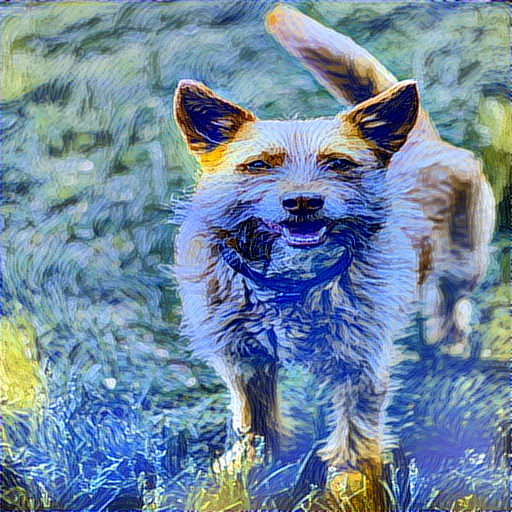

In [19]:
final_image